In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import io
import re

from src.utils.figure import plot_lines
from src.utils.file import get_data_file_path
from src.utils.file import get_evaluation_file_path
from src.utils.metrics import metrics



# Data Presentation

In [2]:
presentation_row = 150
path = get_data_file_path(event_n=3, formula_n=3, count=2000)
data = pd.read_csv(path)

In [3]:
data.head()

,id,context,query,question,code,formula,answer,graph
0,0,"Initially, event3 happened. After event1, even...",C1: Event1 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X ((event1 | event2) & event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
1,1,"Initially, event1 happened. After event3, no o...",C1: Event2 eventually happens.\nC2: If event2 ...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(G (event2 -> (F event2))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
2,2,"Initially, event2 happened. After event2, even...",C1: Event3 happens in the next state.\nC2: Eve...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",((X event3) -> (X event3)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
3,3,"Initially, event3 happened. After event1, eith...",C1: Event2 happens and event3 happens.\nC2: Ev...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event1 | (event2 & event3))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
4,4,"Initially, event2 happened. After event1, even...",C1: Event3 happens or event3 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event3 | event3) | event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2000 non-null   int64 
 1   context   2000 non-null   object
 2   query     2000 non-null   object
 3   question  2000 non-null   object
 4   code      2000 non-null   object
 5   formula   2000 non-null   object
 6   answer    2000 non-null   bool  
 7   graph     2000 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 111.5+ KB


In [5]:
# Context
print(data.loc[presentation_row, 'context'])

Initially, event1 happened. After event2, no other events can happen. After event1, event2 must happen. After event3, event1 must happen.


In [6]:
# Query 
print(data.loc[presentation_row, 'query'])

C1: Event3 does not happen.
C2: Event3 happens or C1 holds.
C3: C2 eventually holds.


In [7]:
# Question
print(data.loc[presentation_row, 'question'])

=== Context ===

Initially, event1 happened. After event2, no other events can happen. After event1, event2 must happen. After event3, event1 must happen.

=== Hypothesis ===

C1: Event3 does not happen.
C2: Event3 happens or C1 holds.
C3: C2 eventually holds.

C3 is True or False?



In [8]:
# Code
print(data.loc[presentation_row, 'code'])

MODULE main
VAR
    state : {event1, event2, event3};
ASSIGN
    init(state) := event1;
    next(state) := case
        state = event1 : event2;
		state = event2 : event2;
		state = event3 : event1;
    esac;
LTLSPEC (F ((state=event3) | (! (state=event3))))



In [9]:
# Formula
print(data.loc[presentation_row, 'formula'])

(F (event3 | (! event3)))


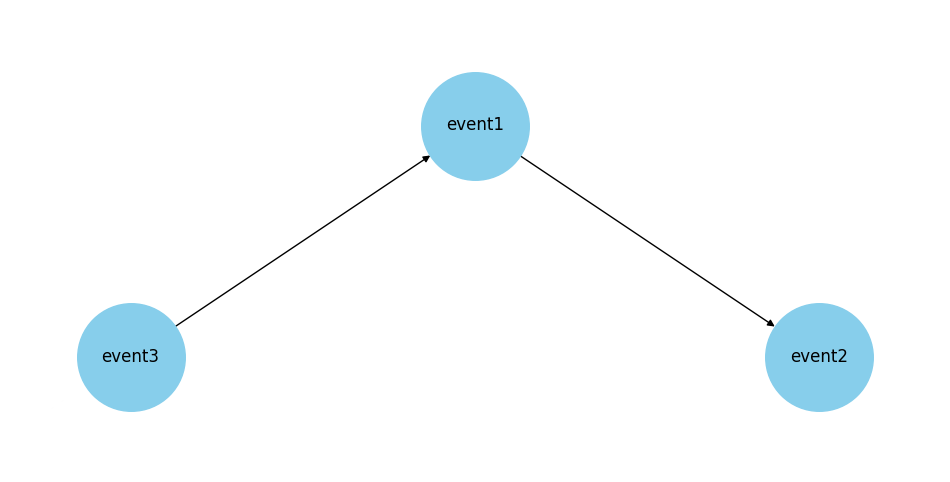

In [10]:
# Plot Graph
graph = nx.read_graphml(io.StringIO(data.loc[presentation_row, 'graph']))
plt.figure(figsize=(12, 6))
plt.xlim(-2.7, 2.7)
plt.ylim(-1.0, 3.0)
pos = {"event1": (0, 2), "event2": (2, 0), "event3": (-2, 0)}
nx.draw(graph, pos, with_labels=True, node_size=6000, node_color='skyblue')
plt.show()

In [11]:
# Answer
print(data.loc[presentation_row, 'answer'])

True


# Prediction Presentation


In [12]:
strategy = "direct"  # Options: direct, zero_shot_cot, few_shot_cot, self_consistency, least_to_most
path = get_evaluation_file_path(event_n=3, formula_n=3, count=2000, model="gpt-4o-mini", strategy=strategy)
data = pd.read_csv(path)

In [13]:
data.head()

,id,context,query,question,code,formula,answer,graph,prediction,prediction_raw
0,0,"Initially, event3 happened. After event1, even...",C1: Event1 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X ((event1 | event2) & event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",1,True
1,1,"Initially, event1 happened. After event3, no o...",C1: Event2 eventually happens.\nC2: If event2 ...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(G (event2 -> (F event2))),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",1,True
2,2,"Initially, event2 happened. After event2, even...",C1: Event3 happens in the next state.\nC2: Eve...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",((X event3) -> (X event3)),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",1,True
3,3,"Initially, event3 happened. After event1, eith...",C1: Event2 happens and event3 happens.\nC2: Ev...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event1 | (event2 & event3))),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,"To determine whether C3 is True or False, let'..."
4,4,"Initially, event2 happened. After event1, even...",C1: Event3 happens or event3 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event3 | event3) | event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,"To determine the truth value of C3, we need to..."


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2000 non-null   int64 
 1   context         2000 non-null   object
 2   query           2000 non-null   object
 3   question        2000 non-null   object
 4   code            2000 non-null   object
 5   formula         2000 non-null   object
 6   answer          2000 non-null   bool  
 7   graph           2000 non-null   object
 8   prediction      2000 non-null   int64 
 9   prediction_raw  2000 non-null   object
dtypes: bool(1), int64(2), object(7)
memory usage: 142.7+ KB


In [15]:
data['answer'] = data['answer'].apply(lambda x: 1 if x else 0)
data['prediction'] = data['prediction'].astype(int)

In [16]:
# Accuracy
print(f'{len(data[data["answer"] == data["prediction"]]) * 100 / len(data)}%')

63.5%


In [17]:
# Prediction Distribution
data['prediction'].value_counts()

prediction
1    1200
0     800
Name: count, dtype: int64

In [18]:
# Precision, Recall, F1
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(data['answer'], data['prediction'], average='macro')
recall = recall_score(data['answer'], data['prediction'], average='macro')
f1 = f1_score(data['answer'], data['prediction'], average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Precision: 0.640625
Recall: 0.635
F1: 0.6313131313131313


# LLMs Evaluation


In [19]:
models = ["gpt-3.5-turbo", "gpt-4o-mini", "gpt-5-mini", "gemma3:12b-it-q8_0", "mistral:7b-instruct",
          "deepseek-reasoner",
          "deepseek-chat", "phi4:14b", "qwen-turbo", "qwen2.5-72b-instruct", "qwen3-14b", "qwen3-32b"]
strategies = ["direct", "zero_shot_cot", "few_shot_cot", "self_consistency", "least_to_most"]

## 1. LTLBench: Event 3, Operator 3, Count 2000

In [20]:
# show results
def show_results(_models: list[str], _strategy: str, _event_n=3, _formula_n=3, _count=2000):
    _models_metrics = {}
    for _model in _models:
        _path = get_evaluation_file_path(
            event_n=_event_n,
            formula_n=_formula_n,
            count=_count,
            model=_model,
            strategy=_strategy,
        )

        if not os.path.exists(_path):
            warnings.warn(f"Evaluation file of model '{_model}' with strategy '{_strategy}' does not exist.",
                          UserWarning)
            continue

        _data = pd.read_csv(_path)
        _data["answer"] = _data["answer"].apply(lambda x: 1 if x else 0)
        _data["prediction"] = _data["prediction"].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
        _models_metrics[_model] = metrics(_data)["raw"]
    return pd.DataFrame(_models_metrics).transpose()

### Direct

In [21]:
show_results(models, "direct")

,accuracy,precision,recall,f1,auc
gpt-3.5-turbo,0.5325,0.551861,0.5325,0.484377,0.5325
gpt-4o-mini,0.6350,0.640625,0.6350,0.631313,0.6350
gpt-5-mini,0.7970,0.797076,0.7970,0.796987,0.7970
gemma3:12b-it-q8_0,0.6015,0.601904,0.6015,0.601104,0.6015
mistral:7b-instruct,0.5560,0.556044,0.5560,0.555913,0.5560
deepseek-reasoner,0.7155,0.735738,0.7155,0.709260,0.7155
deepseek-chat,0.8010,0.801059,0.8010,0.800990,0.8010
phi4:14b,0.6665,0.683088,0.6665,0.658771,0.6665
qwen-turbo,0.6650,0.665519,0.6650,0.664737,0.6650
qwen2.5-72b-instruct,0.5905,0.610680,0.5905,0.570943,0.5905


### Zero-Shot Cot

In [22]:
show_results(models, "zero_shot_cot")

,accuracy,precision,recall,f1,auc
gpt-3.5-turbo,0.5655,0.569683,0.5655,0.558880,0.5655
gpt-4o-mini,0.6260,0.626267,0.6260,0.625802,0.6260
gpt-5-mini,0.7845,0.785861,0.7845,0.784243,0.7845
gemma3:12b-it-q8_0,0.6720,0.675145,0.6720,0.670521,0.6720
mistral:7b-instruct,0.5735,0.573663,0.5735,0.573264,0.5735
deepseek-reasoner,0.6995,0.724719,0.6995,0.690826,0.6995
deepseek-chat,0.7865,0.786548,0.7865,0.786491,0.7865
phi4:14b,0.6560,0.669686,0.6560,0.648921,0.6560
qwen-turbo,0.6760,0.676594,0.6760,0.675727,0.6760
qwen2.5-72b-instruct,0.6810,0.691110,0.6810,0.676725,0.6810


### Few-Shot Cot

In [23]:
show_results(models, "few_shot_cot")

,accuracy,precision,recall,f1,auc
gpt-3.5-turbo,0.6040,0.604376,0.6040,0.603643,0.6040
gpt-4o-mini,0.7155,0.715635,0.7155,0.715456,0.7155
gpt-5-mini,0.9395,0.940933,0.9395,0.939451,0.9395
gemma3:12b-it-q8_0,0.7840,0.784551,0.7840,0.783895,0.7840
mistral:7b-instruct,0.6025,0.602503,0.6025,0.602498,0.6025
deepseek-reasoner,0.8110,0.834299,0.8110,0.807648,0.8110
deepseek-chat,0.9040,0.904079,0.9040,0.903995,0.9040
phi4:14b,0.7350,0.740862,0.7350,0.733378,0.7350
qwen-turbo,0.7870,0.787093,0.7870,0.786983,0.7870
qwen2.5-72b-instruct,0.7605,0.768730,0.7605,0.758652,0.7605


### Self-Consistency

In [24]:
show_results(models, "self_consistency")

,accuracy,precision,recall,f1,auc
gpt-3.5-turbo,0.5710,0.578022,0.5710,0.561125,0.5710
gpt-4o-mini,0.6325,0.632995,0.6325,0.632158,0.6325
gpt-5-mini,0.8035,0.803525,0.8035,0.803496,0.8035
gemma3:12b-it-q8_0,0.6820,0.687416,0.6820,0.679686,0.6820
mistral:7b-instruct,0.5900,0.590001,0.5900,0.589998,0.5900
deepseek-reasoner,0.7370,0.743387,0.7370,0.735263,0.7370
deepseek-chat,0.7940,0.794005,0.7940,0.793999,0.7940
phi4:14b,0.6590,0.676147,0.6590,0.650494,0.6590
qwen-turbo,0.6890,0.689273,0.6890,0.688888,0.6890
qwen2.5-72b-instruct,0.6775,0.688445,0.6775,0.672748,0.6775


### Least-to-Most

In [25]:
show_results(models, "least_to_most")

,accuracy,precision,recall,f1,auc
gpt-3.5-turbo,0.5105,0.537608,0.5105,0.402903,0.5105
gpt-4o-mini,0.6370,0.638740,0.6370,0.635858,0.6370
gpt-5-mini,0.7775,0.777600,0.7775,0.777480,0.7775
gemma3:12b-it-q8_0,0.6720,0.678302,0.6720,0.669076,0.6720
mistral:7b-instruct,0.5770,0.577379,0.5770,0.576481,0.5770
deepseek-reasoner,0.7275,0.740324,0.7275,0.723816,0.7275
deepseek-chat,0.8105,0.810570,0.8105,0.810489,0.8105
phi4:14b,0.6615,0.679290,0.6615,0.652889,0.6615
qwen-turbo,0.6960,0.696095,0.6960,0.695963,0.6960
qwen2.5-72b-instruct,0.6990,0.710320,0.6990,0.694895,0.6990


## 2. Event 2, Operator 1-9, Count 300

In [26]:
models = ["deepseek-reasoner", "gpt-5-mini", "qwen-turbo"]

In [27]:
def show_results_across_formulas(_models: list[str], _strategy: str, _event_n=2, _count=300,
                                 _formulas: Union[list[int], None] = None):
    if _formulas is None:
        _formulas = [1, 2, 3, 4, 5, 7, 9]
    all_models_df = pd.DataFrame()
    for _model in _models:
        model_data = {}
        for _formula_n in _formulas:
            _path = get_evaluation_file_path(
                event_n=_event_n,
                formula_n=_formula_n,
                count=_count,
                model=_model,
                strategy=_strategy
            )
            if not os.path.exists(_path):
                warnings.warn(
                    f"Evaluation file for model '{_model}', strategy '{_strategy}', formula {_formula_n} does not exist.",
                    UserWarning
                )
                continue
            _df = pd.read_csv(_path)
            _df["answer"] = _df["answer"].apply(lambda x: 1 if x else 0)
            _df["prediction"] = _df["prediction"].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
            model_data[_formula_n] = metrics(_df)["raw"]

        # Convert per-model data into a DataFrame
        model_df = (
            pd.DataFrame(model_data)
            .transpose()
            .reset_index()
            .rename(columns={"index": "number_of_operators"})
        )
        model_df["model"] = _model

        # Combine all models' data
        all_models_df = pd.concat([all_models_df, model_df], ignore_index=True)

    return all_models_df

### Direct

In [28]:
direct_fixed_e_df = show_results_across_formulas(models, "direct")
direct_fixed_e_df

,number_of_operators,accuracy,precision,recall,f1,auc,model
0,1,0.743333,0.744649,0.743333,0.742988,0.743333,deepseek-reasoner
1,2,0.796667,0.796785,0.796667,0.796646,0.796667,deepseek-reasoner
2,3,0.706667,0.710407,0.706667,0.705357,0.706667,deepseek-reasoner
3,4,0.750000,0.777216,0.750000,0.743709,0.750000,deepseek-reasoner
4,5,0.706667,0.749250,0.706667,0.693579,0.706667,deepseek-reasoner
5,7,0.693333,0.743343,0.693333,0.676724,0.693333,deepseek-reasoner
6,9,0.623333,0.705937,0.623333,0.581352,0.623333,deepseek-reasoner
7,1,0.760000,0.770833,0.760000,0.757576,0.760000,gpt-5-mini
8,2,0.793333,0.793803,0.793333,0.793251,0.793333,gpt-5-mini
9,3,0.716667,0.718306,0.716667,0.716134,0.716667,gpt-5-mini


#### 2.1. Accuracy

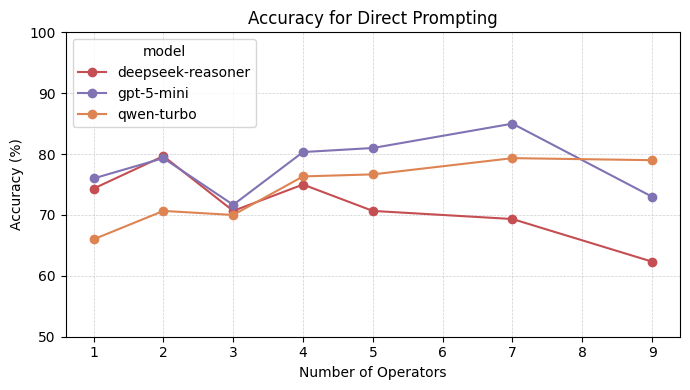

In [29]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(50, 101, 10))
plot_lines(direct_fixed_e_df, x='number_of_operators', y='accuracy', z='model', title='Accuracy for Direct Prompting',
           x_label='Number of Operators',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 2.2. Precision

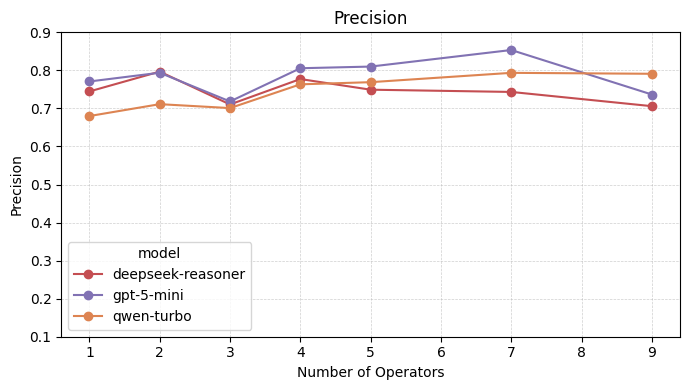

In [30]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_e_df, x='number_of_operators', y='precision', z='model', title='Precision',
           x_label='Number of Operators',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.3. Recall

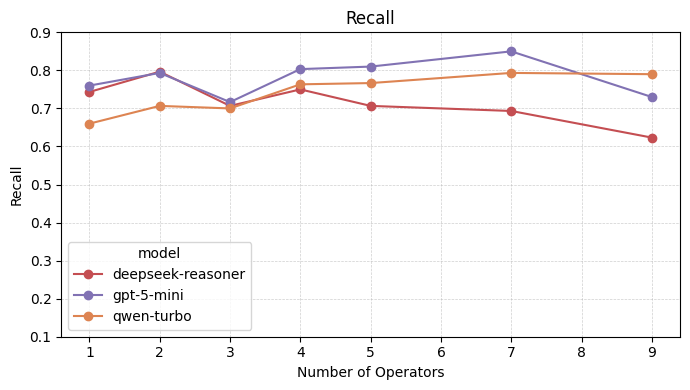

In [31]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_e_df, x='number_of_operators', y='recall', z='model', title='Recall',
           x_label='Number of Operators',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.4. F1

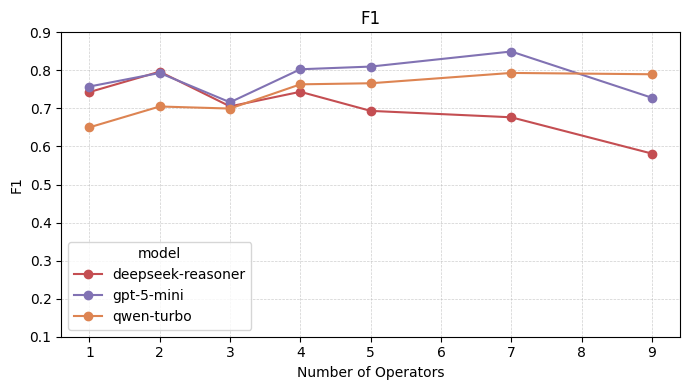

In [32]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_e_df, x='number_of_operators', y='f1', z='model', title='F1', x_label='Number of Operators',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.5. AUC

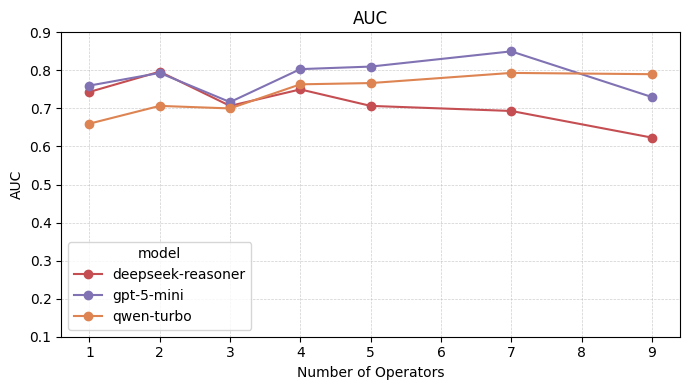

In [33]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_e_df, x='number_of_operators', y='auc', z='model', title='AUC', x_label='Number of Operators',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Zero-Shot CoT

In [34]:
zero_shot_cot_fixed_e_df = show_results_across_formulas(models, "zero_shot_cot")
zero_shot_cot_fixed_e_df

,number_of_operators,accuracy,precision,recall,f1,auc,model
0,1,0.750000,0.751892,0.750000,0.749530,0.750000,deepseek-reasoner
1,2,0.786667,0.786718,0.786667,0.786657,0.786667,deepseek-reasoner
2,3,0.710000,0.713424,0.710000,0.708832,0.710000,deepseek-reasoner
3,4,0.733333,0.774352,0.733333,0.722979,0.733333,deepseek-reasoner
4,5,0.703333,0.743623,0.703333,0.690539,0.703333,deepseek-reasoner
5,7,0.716667,0.783909,0.716667,0.698834,0.716667,deepseek-reasoner
6,9,0.613333,0.691960,0.613333,0.569222,0.613333,deepseek-reasoner
7,1,0.740000,0.752999,0.740000,0.736617,0.740000,gpt-5-mini
8,2,0.783333,0.783648,0.783333,0.783273,0.783333,gpt-5-mini
9,3,0.716667,0.717449,0.716667,0.716411,0.716667,gpt-5-mini


#### 2.1. Accuracy

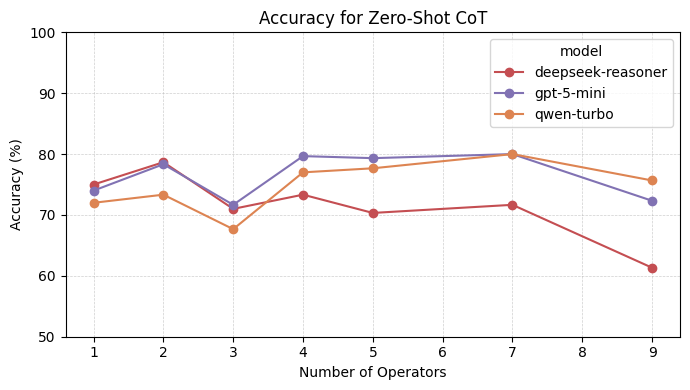

In [35]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(50, 101, 10))
plot_lines(zero_shot_cot_fixed_e_df, x='number_of_operators', y='accuracy', z='model', title='Accuracy for Zero-Shot CoT',
           x_label='Number of Operators',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 2.2. Precision

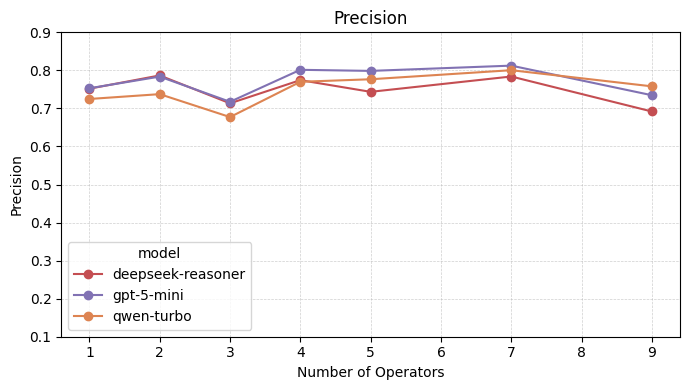

In [36]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_e_df, x='number_of_operators', y='precision', z='model', title='Precision',
           x_label='Number of Operators',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.3. Recall

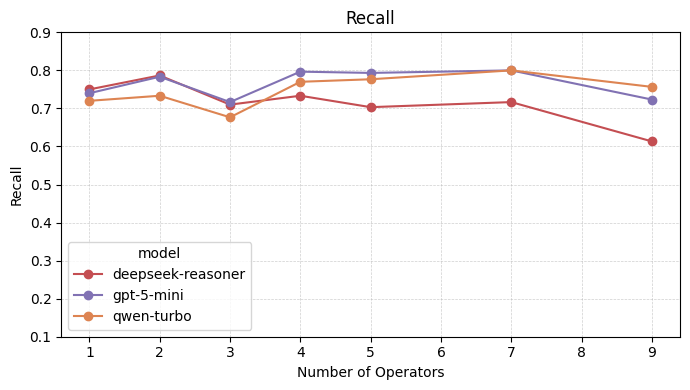

In [37]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_e_df, x='number_of_operators', y='recall', z='model', title='Recall',
           x_label='Number of Operators',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.4. F1

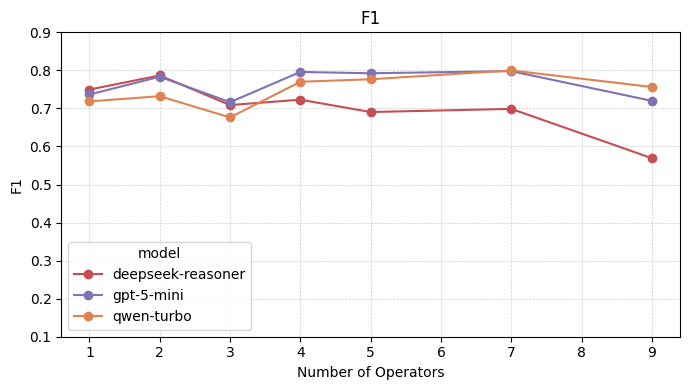

In [38]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_e_df, x='number_of_operators', y='f1', z='model', title='F1',
           x_label='Number of Operators',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.5. AUC

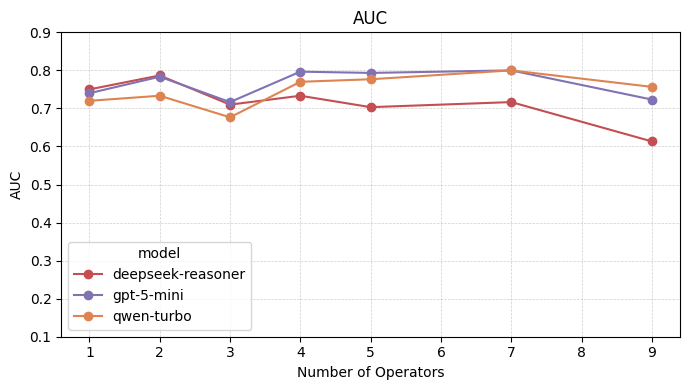

In [39]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_e_df, x='number_of_operators', y='auc', z='model', title='AUC',
           x_label='Number of Operators',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Few-Shot CoT

In [40]:
few_shot_cot_fixed_e_df = show_results_across_formulas(models, "few_shot_cot")
few_shot_cot_fixed_e_df

,number_of_operators,accuracy,precision,recall,f1,auc,model
0,1,0.873333,0.875738,0.873333,0.873130,0.873333,deepseek-reasoner
1,2,0.913333,0.915179,0.913333,0.913237,0.913333,deepseek-reasoner
2,3,0.876667,0.879517,0.876667,0.876435,0.876667,deepseek-reasoner
3,4,0.883333,0.890997,0.883333,0.882759,0.883333,deepseek-reasoner
4,5,0.880000,0.893719,0.880000,0.878945,0.880000,deepseek-reasoner
5,7,0.860000,0.879498,0.860000,0.858178,0.860000,deepseek-reasoner
6,9,0.823333,0.852283,0.823333,0.819628,0.823333,deepseek-reasoner
7,1,0.920000,0.920299,0.920000,0.919986,0.920000,gpt-5-mini
8,2,0.976667,0.976688,0.976667,0.976666,0.976667,gpt-5-mini
9,3,0.963333,0.963849,0.963333,0.963323,0.963333,gpt-5-mini


#### 2.1. Accuracy

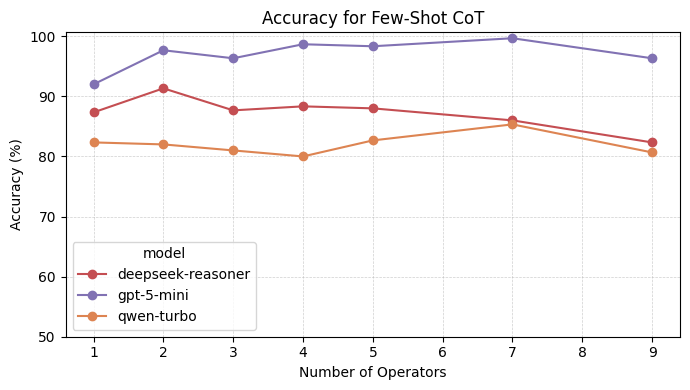

In [41]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(50, 101, 10))
plot_lines(few_shot_cot_fixed_e_df, x='number_of_operators', y='accuracy', z='model', title='Accuracy for Few-Shot CoT',
           x_label='Number of Operators',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 2.2. Precision

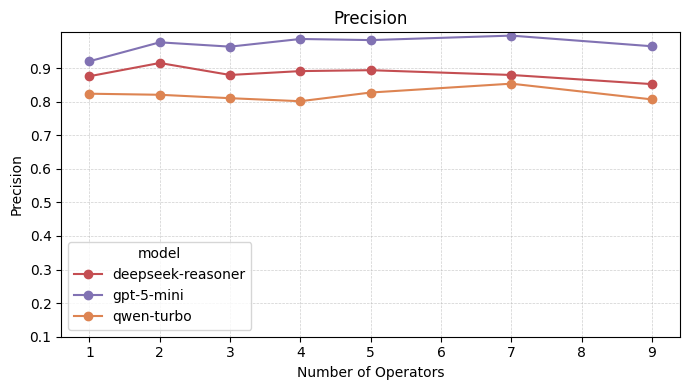

In [42]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_e_df, x='number_of_operators', y='precision', z='model', title='Precision',
           x_label='Number of Operators',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.3. Recall

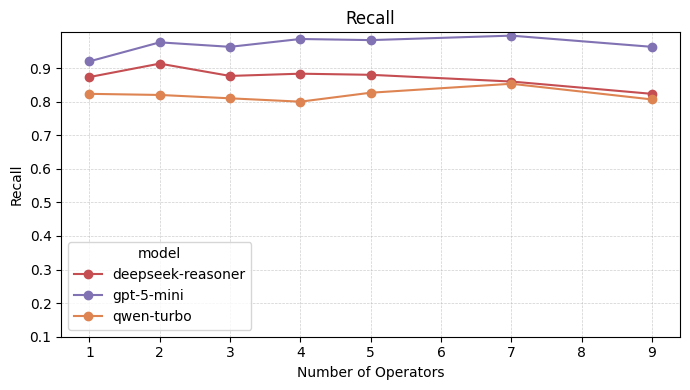

In [43]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_e_df, x='number_of_operators', y='recall', z='model', title='Recall',
           x_label='Number of Operators',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.4. F1

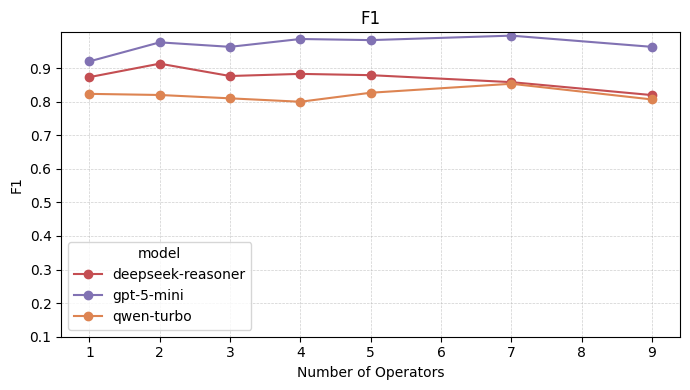

In [44]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_e_df, x='number_of_operators', y='f1', z='model', title='F1',
           x_label='Number of Operators',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.5. AUC

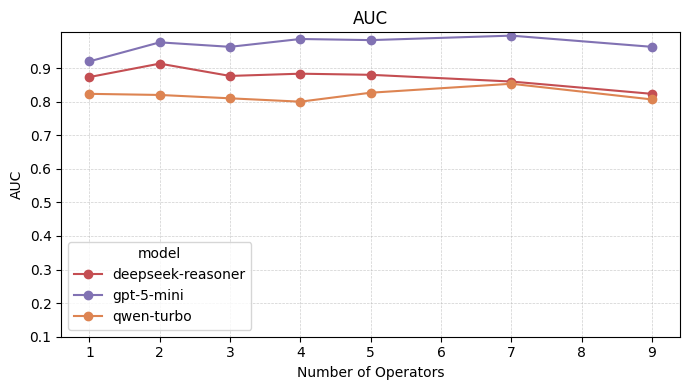

In [45]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_e_df, x='number_of_operators', y='auc', z='model', title='AUC',
           x_label='Number of Operators',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Self-Consistency

In [46]:
self_consistency_fixed_e_df = show_results_across_formulas(models, "self_consistency")
self_consistency_fixed_e_df

,number_of_operators,accuracy,precision,recall,f1,auc,model
0,1,0.723333,0.728711,0.723333,0.721698,0.723333,deepseek-reasoner
1,2,0.793333,0.794643,0.793333,0.793103,0.793333,deepseek-reasoner
2,3,0.750000,0.750278,0.750000,0.749931,0.750000,deepseek-reasoner
3,4,0.793333,0.803923,0.793333,0.791517,0.793333,deepseek-reasoner
4,5,0.773333,0.786366,0.773333,0.770725,0.773333,deepseek-reasoner
5,7,0.740000,0.775735,0.740000,0.731294,0.740000,deepseek-reasoner
6,9,0.680000,0.720061,0.680000,0.664742,0.680000,deepseek-reasoner
7,1,0.743333,0.759098,0.743333,0.739369,0.743333,gpt-5-mini
8,2,0.800000,0.800481,0.800000,0.799920,0.800000,gpt-5-mini
9,3,0.720000,0.722532,0.720000,0.719201,0.720000,gpt-5-mini


#### 2.1. Accuracy

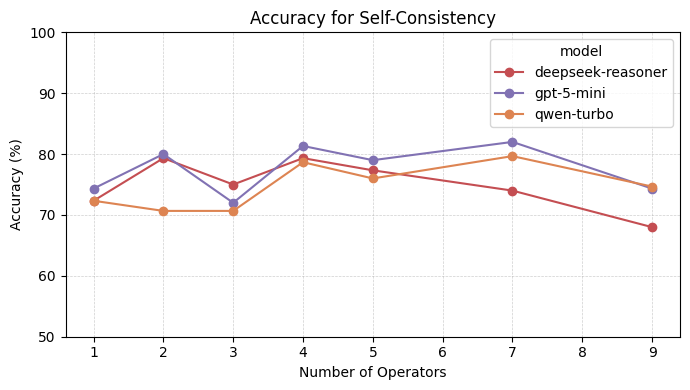

In [47]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(50, 101, 10))
plot_lines(self_consistency_fixed_e_df, x='number_of_operators', y='accuracy', z='model', title='Accuracy for Self-Consistency',
           x_label='Number of Operators',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 2.2. Precision

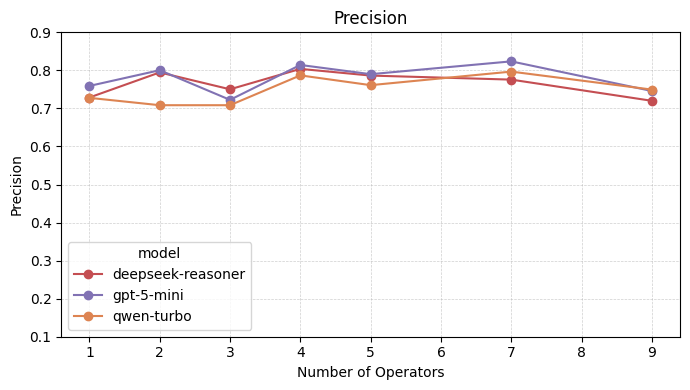

In [48]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_e_df, x='number_of_operators', y='precision', z='model', title='Precision',
           x_label='Number of Operators',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.3. Recall

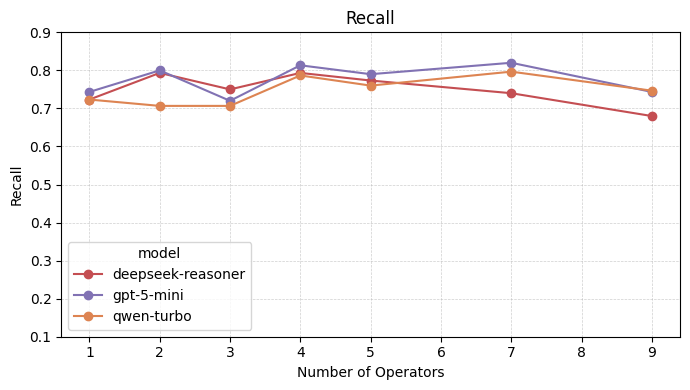

In [49]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_e_df, x='number_of_operators', y='recall', z='model', title='Recall',
           x_label='Number of Operators',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.4. F1

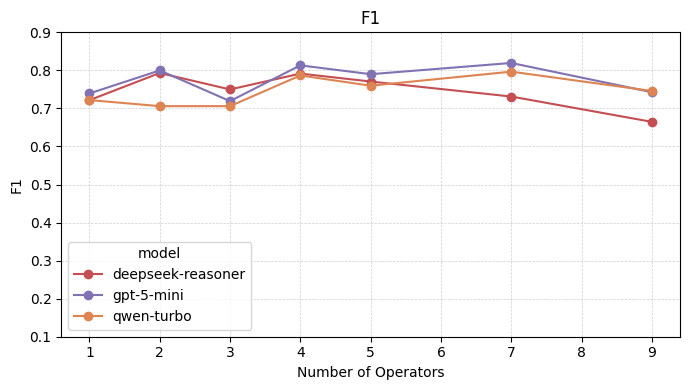

In [50]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_e_df, x='number_of_operators', y='f1', z='model', title='F1',
           x_label='Number of Operators',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.5. AUC

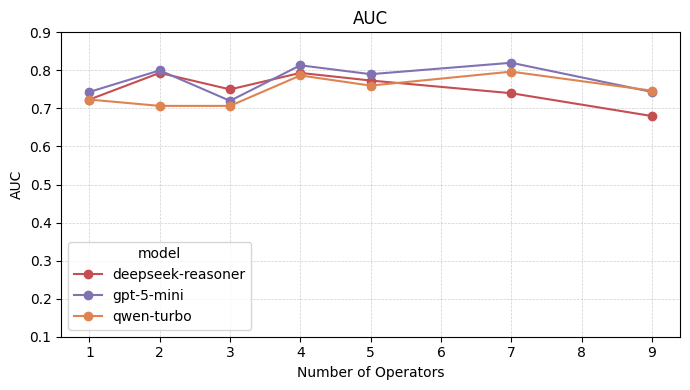

In [51]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_e_df, x='number_of_operators', y='auc', z='model', title='AUC',
           x_label='Number of Operators',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Least-to-Most

In [52]:
least_to_most_fixed_e_df = show_results_across_formulas(models, "least_to_most")
least_to_most_fixed_e_df

,number_of_operators,accuracy,precision,recall,f1,auc,model
0,1,0.736667,0.741398,0.736667,0.735370,0.736667,deepseek-reasoner
1,2,0.796667,0.798271,0.796667,0.796393,0.796667,deepseek-reasoner
2,3,0.766667,0.766714,0.766667,0.766656,0.766667,deepseek-reasoner
3,4,0.756667,0.779647,0.756667,0.751563,0.756667,deepseek-reasoner
4,5,0.766667,0.787081,0.766667,0.762443,0.766667,deepseek-reasoner
5,7,0.750000,0.795757,0.750000,0.739942,0.750000,deepseek-reasoner
6,9,0.676667,0.720698,0.676667,0.659693,0.676667,deepseek-reasoner
7,1,0.766667,0.776294,0.766667,0.764616,0.766667,gpt-5-mini
8,2,0.776667,0.777271,0.776667,0.776545,0.776667,gpt-5-mini
9,3,0.720000,0.721417,0.720000,0.719551,0.720000,gpt-5-mini


#### 2.1. Accuracy

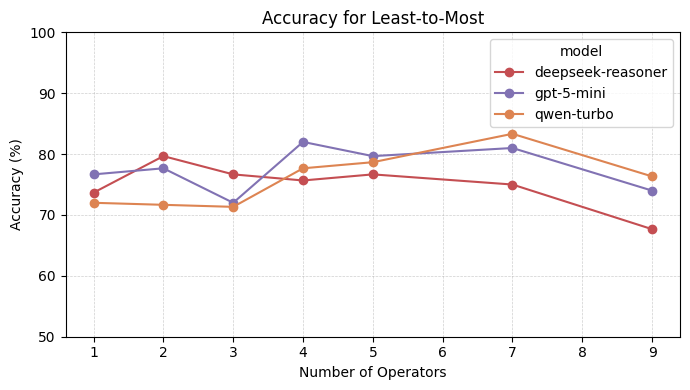

In [53]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(50, 101, 10))
plot_lines(least_to_most_fixed_e_df, x='number_of_operators', y='accuracy', z='model', title='Accuracy for Least-to-Most',
           x_label='Number of Operators',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 2.2. Precision

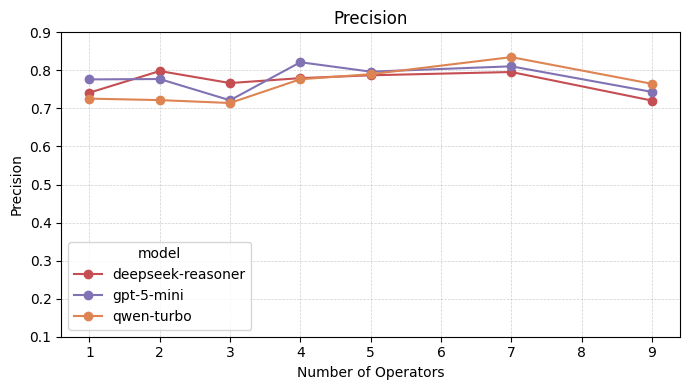

In [54]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_e_df, x='number_of_operators', y='precision', z='model', title='Precision',
           x_label='Number of Operators',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.3. Recall

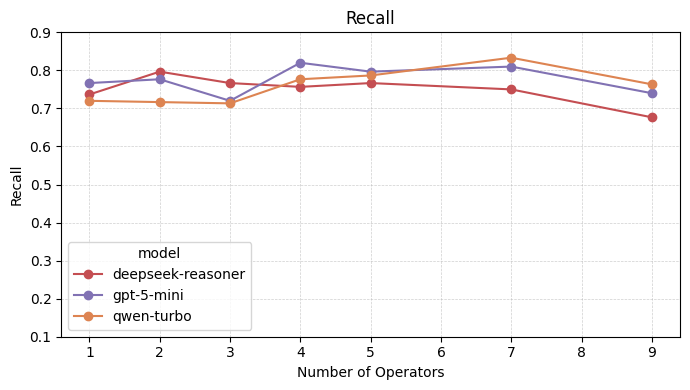

In [55]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_e_df, x='number_of_operators', y='recall', z='model', title='Recall',
           x_label='Number of Operators',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.4. F1

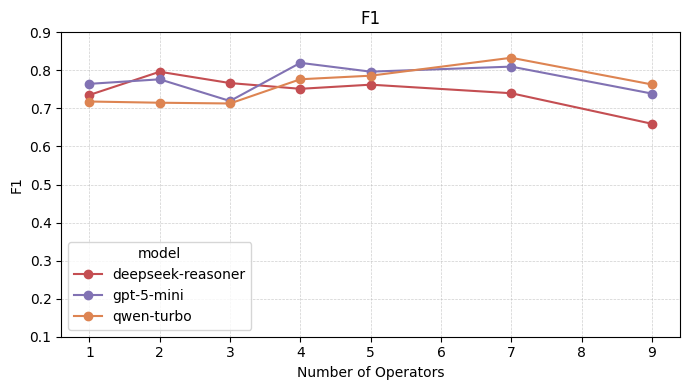

In [56]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_e_df, x='number_of_operators', y='f1', z='model', title='F1',
           x_label='Number of Operators',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 2.5. AUC

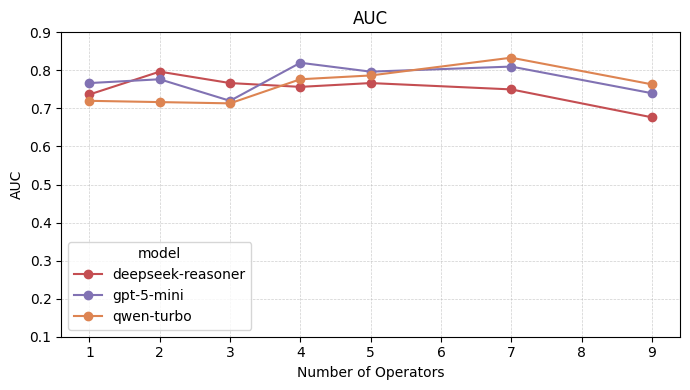

In [57]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_e_df, x='number_of_operators', y='auc', z='model', title='AUC',
           x_label='Number of Operators',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Accuracy Drop Analysis


In [58]:
# Combine all strategy dataframes from this section
all_strategies_df = pd.concat([
    direct_fixed_e_df.assign(strategy='direct'),
    zero_shot_cot_fixed_e_df.assign(strategy='zero_shot_cot'),
    few_shot_cot_fixed_e_df.assign(strategy='few_shot_cot'),
    self_consistency_fixed_e_df.assign(strategy='self_consistency'),
    least_to_most_fixed_e_df.assign(strategy='least_to_most')
], ignore_index=True)

# Calculate accuracy drop from operator 7 to operator 9
# Convert accuracy to percentage (multiply by 100)
op7_data = all_strategies_df[all_strategies_df['number_of_operators'] == 7][['accuracy', 'strategy', 'model']].copy()
op7_data['accuracy'] = op7_data['accuracy'] * 100
op9_data = all_strategies_df[all_strategies_df['number_of_operators'] == 9][['accuracy', 'strategy', 'model']].copy()
op9_data['accuracy'] = op9_data['accuracy'] * 100

# Merge the data on both strategy and model
accuracy_drop_df = op7_data.merge(op9_data, on=['strategy', 'model'], suffixes=('_op7', '_op9'))

# Calculate the drop (in percentage points)
accuracy_drop_df['accuracy_drop'] = accuracy_drop_df['accuracy_op7'] - accuracy_drop_df['accuracy_op9']

# Display the results
print("Accuracy Drop from Operator 7 to Operator 9 (by Model and Strategy):")
print("="*80)
print(accuracy_drop_df[['model', 'strategy', 'accuracy_op7', 'accuracy_op9', 'accuracy_drop']].to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("\nSummary Statistics:")
print(f"Average accuracy drop across all models and methods: {accuracy_drop_df['accuracy_drop'].mean():.2f} percentage points")
print(f"Std deviation: {accuracy_drop_df['accuracy_drop'].std():.2f} percentage points")
print(f"Min drop: {accuracy_drop_df['accuracy_drop'].min():.2f} percentage points")
print(f"Max drop: {accuracy_drop_df['accuracy_drop'].max():.2f} percentage points")

# Breakdown by strategy
print("\n" + "="*80)
print("\nAverage Drop by Strategy:")
strategy_drops = accuracy_drop_df.groupby('strategy')['accuracy_drop'].agg(['mean', 'std']).round(2)
print(strategy_drops.to_string())
print("\nMean Drop by Strategy:")
print(strategy_drops.mean())

# Breakdown by model
print("\n" + "="*80)
print("\nAverage Drop by Model:")
model_drops = accuracy_drop_df.groupby('model')['accuracy_drop'].agg(['mean', 'std']).round(2)
print(model_drops.to_string())
print("\nMean Drop by Model:")
print(model_drops.mean())


Accuracy Drop from Operator 7 to Operator 9 (by Model and Strategy):
            model         strategy  accuracy_op7  accuracy_op9  accuracy_drop
deepseek-reasoner           direct     69.333333     62.333333       7.000000
       gpt-5-mini           direct     85.000000     73.000000      12.000000
       qwen-turbo           direct     79.333333     79.000000       0.333333
deepseek-reasoner    zero_shot_cot     71.666667     61.333333      10.333333
       gpt-5-mini    zero_shot_cot     80.000000     72.333333       7.666667
       qwen-turbo    zero_shot_cot     80.000000     75.666667       4.333333
deepseek-reasoner     few_shot_cot     86.000000     82.333333       3.666667
       gpt-5-mini     few_shot_cot     99.666667     96.333333       3.333333
       qwen-turbo     few_shot_cot     85.333333     80.666667       4.666667
deepseek-reasoner self_consistency     74.000000     68.000000       6.000000
       gpt-5-mini self_consistency     82.000000     74.333333       7.66

## 3. Operator 2, Event 2-9, Count 300

In [59]:
models = ["deepseek-reasoner", "gpt-5-mini", "qwen-turbo"]

In [60]:
def show_results_across_events(_models: list[str], _strategy: str, _formula_n=2, _count=300,
                               _events: Union[list[int], None] = None):
    if _events is None:
        _events = [2, 3, 4, 5, 7, 9]
    all_models_df = pd.DataFrame()
    for _model in _models:
        model_data = {}
        for _event_n in _events:
            _path = get_evaluation_file_path(
                event_n=_event_n,
                formula_n=_formula_n,
                count=_count,
                model=_model,
                strategy=_strategy
            )
            if not os.path.exists(_path):
                warnings.warn(
                    f"Evaluation file for model '{_model}', strategy '{_strategy}', event {_event_n} does not exist.",
                    UserWarning
                )
                continue
            _df = pd.read_csv(_path)
            _df["answer"] = _df["answer"].apply(lambda x: 1 if x else 0)
            _df["prediction"] = _df["prediction"].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
            model_data[_event_n] = metrics(_df)["raw"]

        # Convert per-model data into a DataFrame
        model_df = (
            pd.DataFrame(model_data)
            .transpose()
            .reset_index()
            .rename(columns={"index": "number_of_events"})
        )
        model_df["model"] = _model

        # Combine all models' data
        all_models_df = pd.concat([all_models_df, model_df], ignore_index=True)

    return all_models_df

### Direct

In [61]:
direct_fixed_f_df = show_results_across_events(models, "direct")
direct_fixed_f_df

,number_of_events,accuracy,precision,recall,f1,auc,model
0,2,0.796667,0.796785,0.796667,0.796646,0.796667,deepseek-reasoner
1,3,0.763333,0.768598,0.763333,0.762168,0.763333,deepseek-reasoner
2,4,0.723333,0.747647,0.723333,0.716372,0.723333,deepseek-reasoner
3,5,0.740000,0.767380,0.740000,0.733169,0.740000,deepseek-reasoner
4,7,0.676667,0.727676,0.676667,0.657482,0.676667,deepseek-reasoner
5,9,0.600000,0.660302,0.600000,0.558477,0.600000,deepseek-reasoner
6,2,0.793333,0.793803,0.793333,0.793251,0.793333,gpt-5-mini
7,3,0.800000,0.800213,0.800000,0.799964,0.800000,gpt-5-mini
8,4,0.736667,0.751999,0.736667,0.732599,0.736667,gpt-5-mini
9,5,0.783333,0.801689,0.783333,0.779987,0.783333,gpt-5-mini


#### 3.1. Accuracy

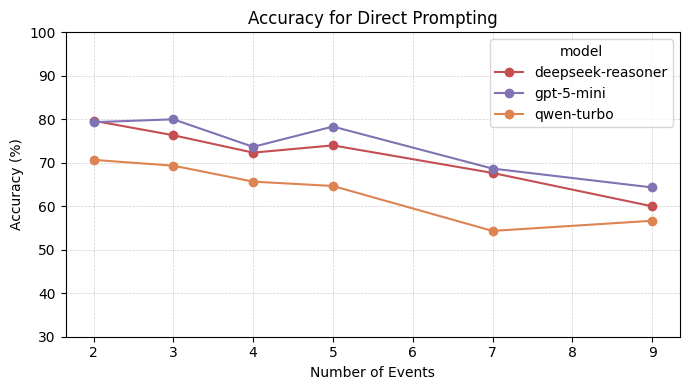

In [62]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(30, 101, 10))
plot_lines(direct_fixed_f_df, x='number_of_events', y='accuracy', z='model', title='Accuracy for Direct Prompting',
           x_label='Number of Events',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 3.2. Precision

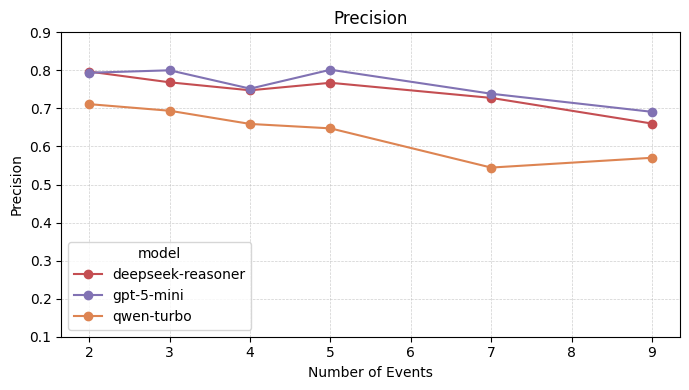

In [63]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_f_df, x='number_of_events', y='precision', z='model', title='Precision',
           x_label='Number of Events',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.3. Recall

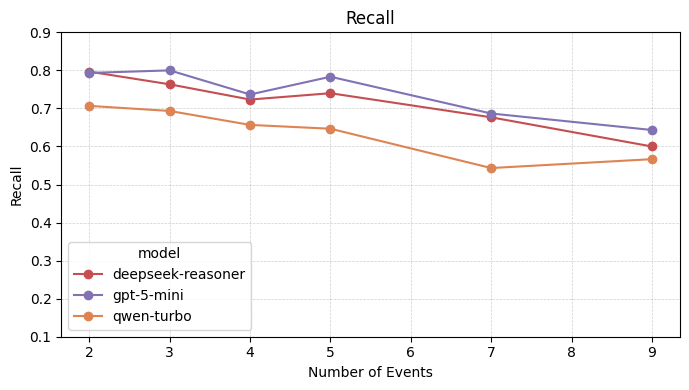

In [64]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_f_df, x='number_of_events', y='recall', z='model', title='Recall',
           x_label='Number of Events',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.4. F1

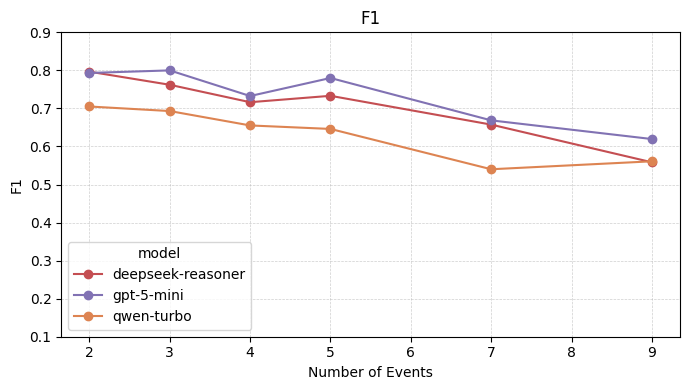

In [65]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_f_df, x='number_of_events', y='f1', z='model', title='F1', x_label='Number of Events',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.5. AUC

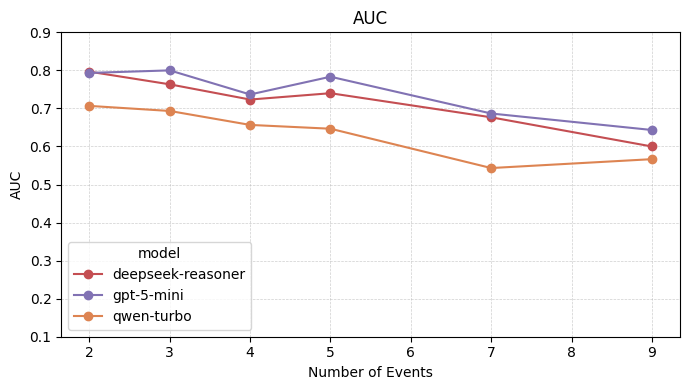

In [66]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(direct_fixed_f_df, x='number_of_events', y='auc', z='model', title='AUC', x_label='Number of Events',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Zero-Shot CoT

In [67]:
zero_shot_cot_fixed_f_df = show_results_across_events(models, "zero_shot_cot")
zero_shot_cot_fixed_f_df

,number_of_events,accuracy,precision,recall,f1,auc,model
0,2,0.786667,0.786718,0.786667,0.786657,0.786667,deepseek-reasoner
1,3,0.726667,0.738943,0.726667,0.723110,0.726667,deepseek-reasoner
2,4,0.713333,0.737671,0.713333,0.705802,0.713333,deepseek-reasoner
3,5,0.723333,0.750012,0.723333,0.715750,0.723333,deepseek-reasoner
4,7,0.696667,0.745683,0.696667,0.680743,0.696667,deepseek-reasoner
5,9,0.593333,0.649615,0.593333,0.551119,0.593333,deepseek-reasoner
6,2,0.783333,0.783648,0.783333,0.783273,0.783333,gpt-5-mini
7,3,0.800000,0.801339,0.800000,0.799778,0.800000,gpt-5-mini
8,4,0.746667,0.763583,0.746667,0.742536,0.746667,gpt-5-mini
9,5,0.780000,0.801435,0.780000,0.776018,0.780000,gpt-5-mini


#### 3.1. Accuracy

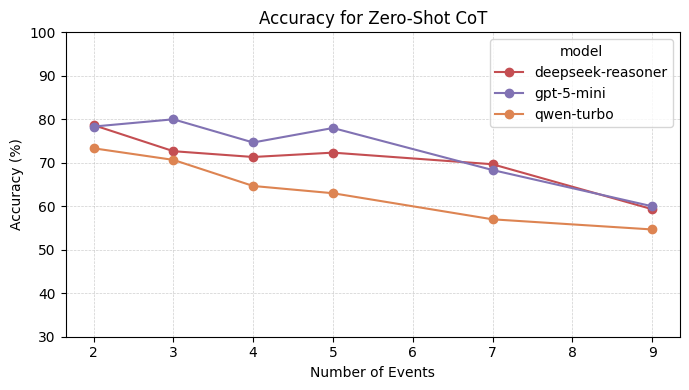

In [68]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(30, 101, 10))
plot_lines(zero_shot_cot_fixed_f_df, x='number_of_events', y='accuracy', z='model', title='Accuracy for Zero-Shot CoT',
           x_label='Number of Events',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 3.2. Precision

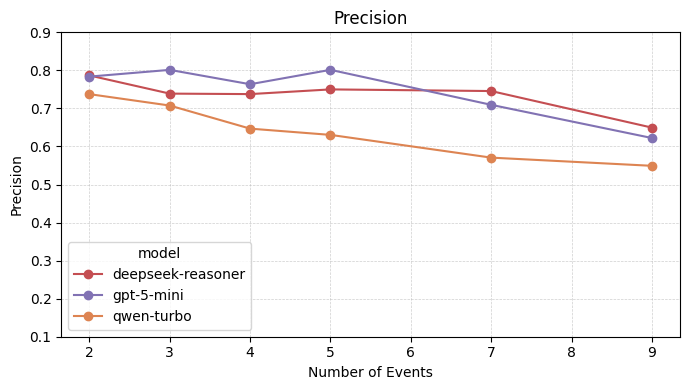

In [69]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_f_df, x='number_of_events', y='precision', z='model', title='Precision',
           x_label='Number of Events',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.3. Recall

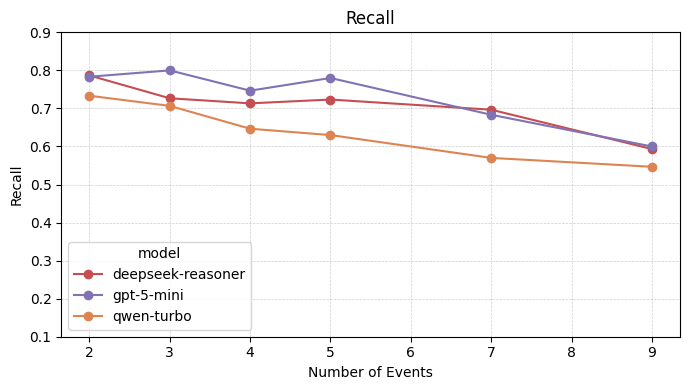

In [70]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_f_df, x='number_of_events', y='recall', z='model', title='Recall',
           x_label='Number of Events',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.4. F1

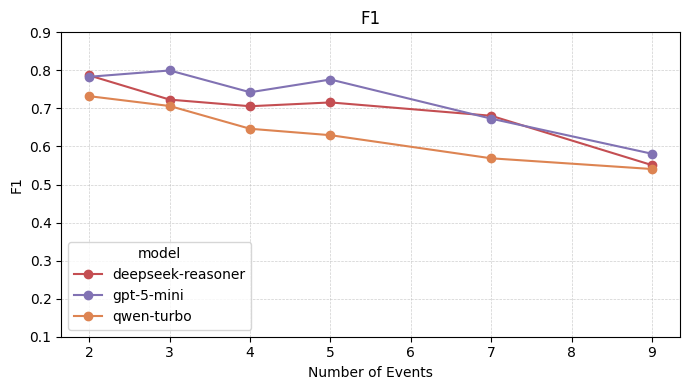

In [71]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_f_df, x='number_of_events', y='f1', z='model', title='F1', x_label='Number of Events',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.5. AUC

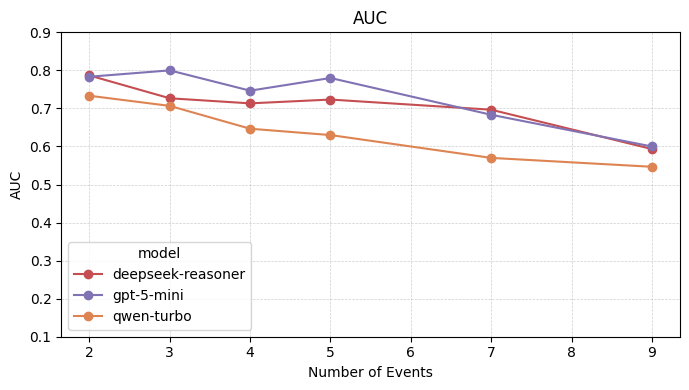

In [72]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(zero_shot_cot_fixed_f_df, x='number_of_events', y='auc', z='model', title='AUC', x_label='Number of Events',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Few-Shot CoT

In [73]:
few_shot_cot_fixed_f_df = show_results_across_events(models, "few_shot_cot")
few_shot_cot_fixed_f_df

,number_of_events,accuracy,precision,recall,f1,auc,model
0,2,0.913333,0.915179,0.913333,0.913237,0.913333,deepseek-reasoner
1,3,0.840000,0.854167,0.840000,0.838384,0.840000,deepseek-reasoner
2,4,0.813333,0.842832,0.813333,0.809230,0.813333,deepseek-reasoner
3,5,0.763333,0.804236,0.763333,0.755102,0.763333,deepseek-reasoner
4,7,0.716667,0.770668,0.716667,0.701793,0.716667,deepseek-reasoner
5,9,0.686667,0.725129,0.686667,0.672687,0.686667,deepseek-reasoner
6,2,0.976667,0.976688,0.976667,0.976666,0.976667,gpt-5-mini
7,3,0.960000,0.960000,0.960000,0.960000,0.960000,gpt-5-mini
8,4,0.936667,0.939971,0.936667,0.936548,0.936667,gpt-5-mini
9,5,0.893333,0.895867,0.893333,0.893162,0.893333,gpt-5-mini


#### 3.1. Accuracy

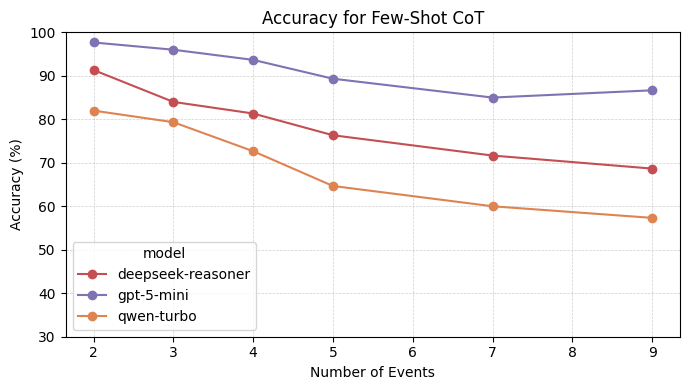

In [74]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(30, 101, 10))
plot_lines(few_shot_cot_fixed_f_df, x='number_of_events', y='accuracy', z='model', title='Accuracy for Few-Shot CoT',
           x_label='Number of Events',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 3.2. Precision

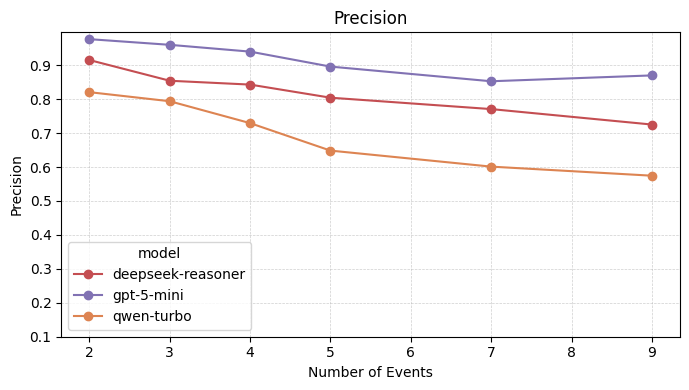

In [75]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_f_df, x='number_of_events', y='precision', z='model', title='Precision',
           x_label='Number of Events',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.3. Recall

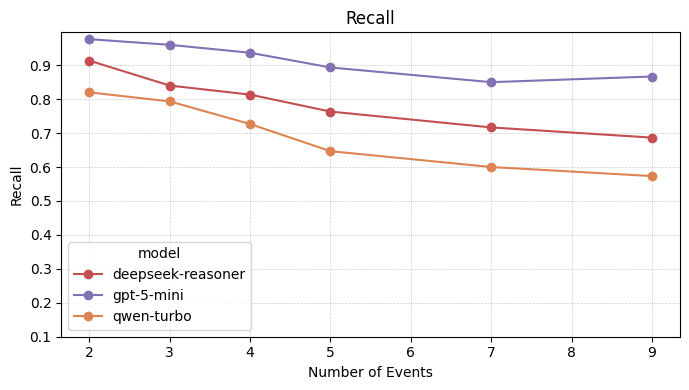

In [76]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_f_df, x='number_of_events', y='recall', z='model', title='Recall',
           x_label='Number of Events',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.4. F1

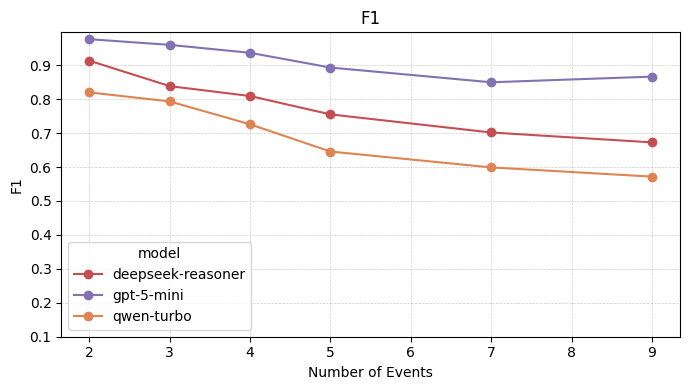

In [77]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_f_df, x='number_of_events', y='f1', z='model', title='F1', x_label='Number of Events',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.5. AUC

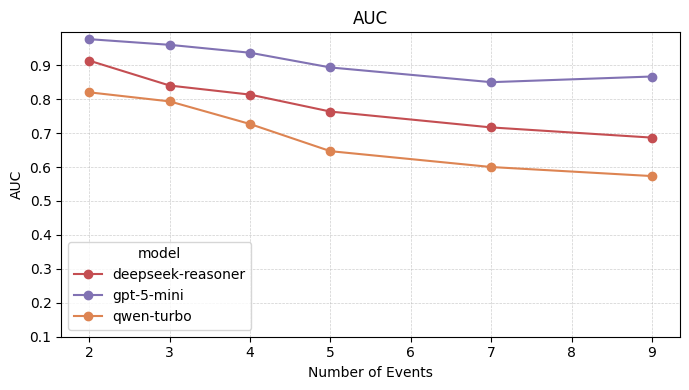

In [78]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(few_shot_cot_fixed_f_df, x='number_of_events', y='auc', z='model', title='AUC', x_label='Number of Events',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Self-Consistency

In [79]:
self_consistency_fixed_f_df = show_results_across_events(models, "self_consistency")
self_consistency_fixed_f_df

,number_of_events,accuracy,precision,recall,f1,auc,model
0,2,0.793333,0.794643,0.793333,0.793103,0.793333,deepseek-reasoner
1,3,0.780000,0.780799,0.780000,0.779843,0.780000,deepseek-reasoner
2,4,0.726667,0.737474,0.726667,0.723521,0.726667,deepseek-reasoner
3,5,0.773333,0.784722,0.773333,0.771044,0.773333,deepseek-reasoner
4,7,0.656667,0.670694,0.656667,0.649465,0.656667,deepseek-reasoner
5,9,0.590000,0.612431,0.590000,0.568477,0.590000,deepseek-reasoner
6,2,0.800000,0.800481,0.800000,0.799920,0.800000,gpt-5-mini
7,3,0.810000,0.810124,0.810000,0.809981,0.810000,gpt-5-mini
8,4,0.770000,0.785546,0.770000,0.766826,0.770000,gpt-5-mini
9,5,0.806667,0.832755,0.806667,0.802802,0.806667,gpt-5-mini


#### 3.1. Accuracy

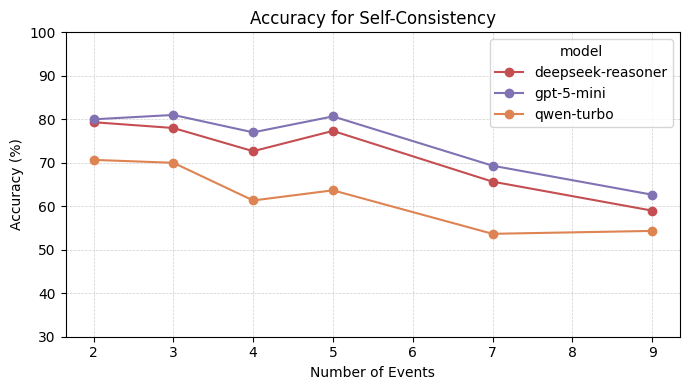

In [80]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(30, 101, 10))
plot_lines(self_consistency_fixed_f_df, x='number_of_events', y='accuracy', z='model', title='Accuracy for Self-Consistency',
           x_label='Number of Events',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 3.2. Precision

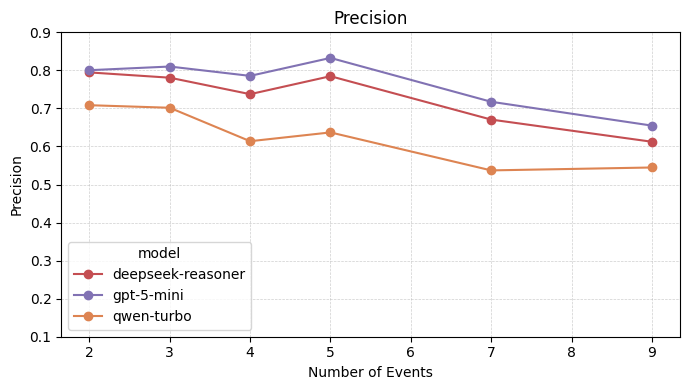

In [81]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_f_df, x='number_of_events', y='precision', z='model', title='Precision',
           x_label='Number of Events',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.3. Recall

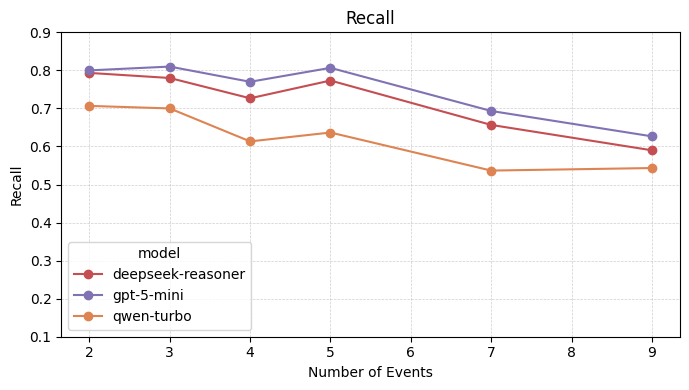

In [82]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_f_df, x='number_of_events', y='recall', z='model', title='Recall',
           x_label='Number of Events',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.4. F1

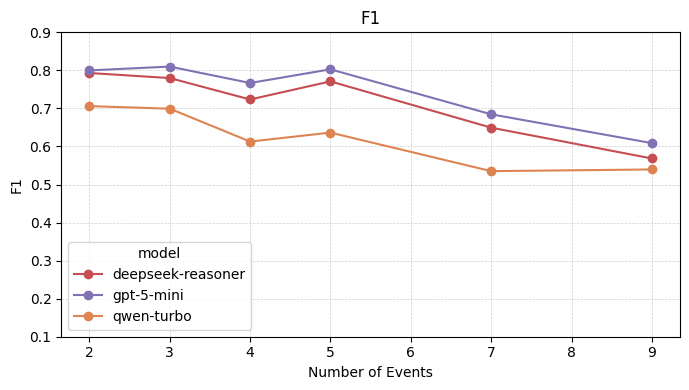

In [83]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_f_df, x='number_of_events', y='f1', z='model', title='F1', x_label='Number of Events',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.5. AUC

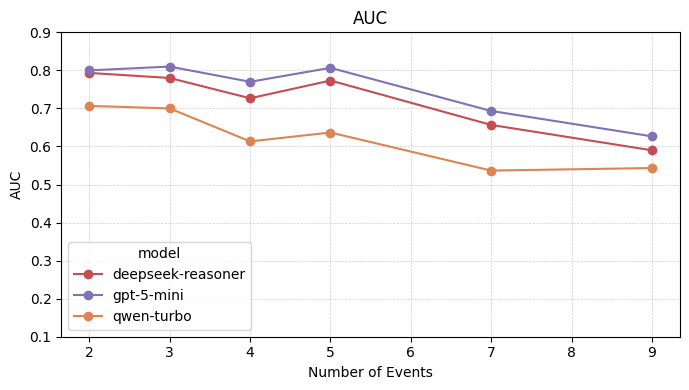

In [84]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(self_consistency_fixed_f_df, x='number_of_events', y='auc', z='model', title='AUC',
           x_label='Number of Events',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Least-to-Most

In [85]:
least_to_most_fixed_f_df = show_results_across_events(models, "least_to_most")
least_to_most_fixed_f_df

,number_of_events,accuracy,precision,recall,f1,auc,model
0,2,0.796667,0.798271,0.796667,0.796393,0.796667,deepseek-reasoner
1,3,0.763333,0.767627,0.763333,0.762380,0.763333,deepseek-reasoner
2,4,0.740000,0.756459,0.740000,0.735760,0.740000,deepseek-reasoner
3,5,0.743333,0.757344,0.743333,0.739792,0.743333,deepseek-reasoner
4,7,0.726667,0.757628,0.726667,0.718200,0.726667,deepseek-reasoner
5,9,0.626667,0.677019,0.626667,0.598086,0.626667,deepseek-reasoner
6,2,0.776667,0.777271,0.776667,0.776545,0.776667,gpt-5-mini
7,3,0.793333,0.793803,0.793333,0.793251,0.793333,gpt-5-mini
8,4,0.763333,0.768598,0.763333,0.762168,0.763333,gpt-5-mini
9,5,0.750000,0.754998,0.750000,0.748769,0.750000,gpt-5-mini


#### 3.1. Accuracy

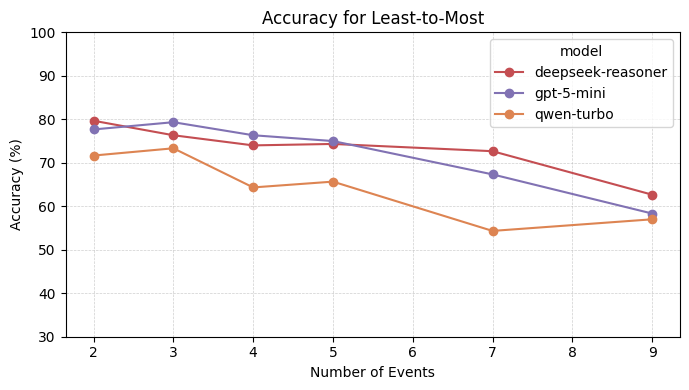

In [86]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(30, 101, 10))
plot_lines(least_to_most_fixed_f_df, x='number_of_events', y='accuracy', z='model', title='Accuracy for Least-to-Most',
           x_label='Number of Events',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

#### 3.2. Precision

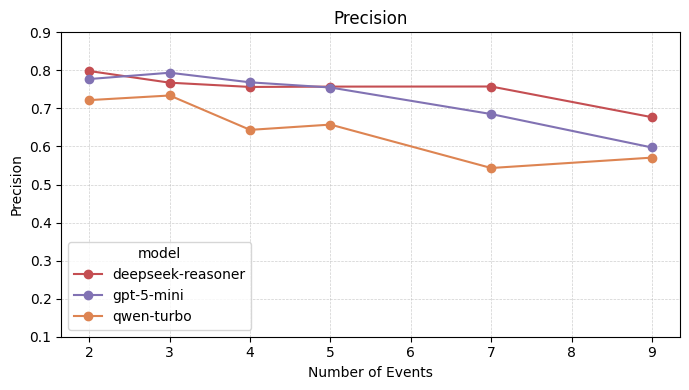

In [87]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_f_df, x='number_of_events', y='precision', z='model', title='Precision',
           x_label='Number of Events',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.3. Recall

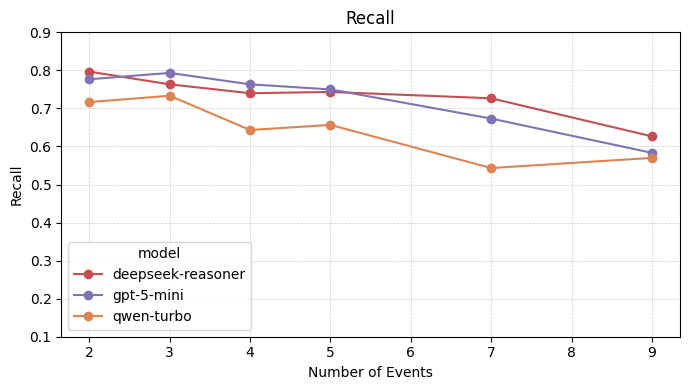

In [88]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_f_df, x='number_of_events', y='recall', z='model', title='Recall',
           x_label='Number of Events',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.4. F1

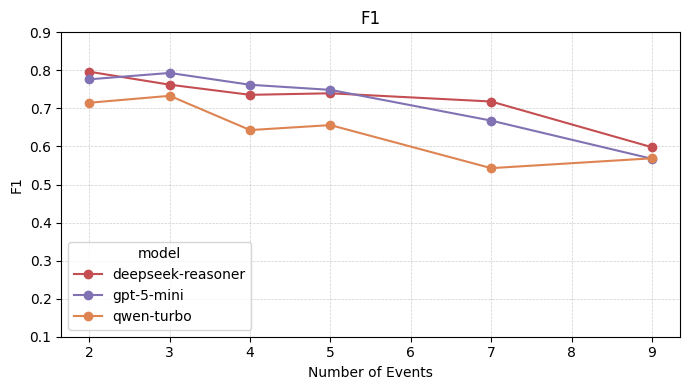

In [89]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_f_df, x='number_of_events', y='f1', z='model', title='F1', x_label='Number of Events',
           y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

#### 3.5. AUC

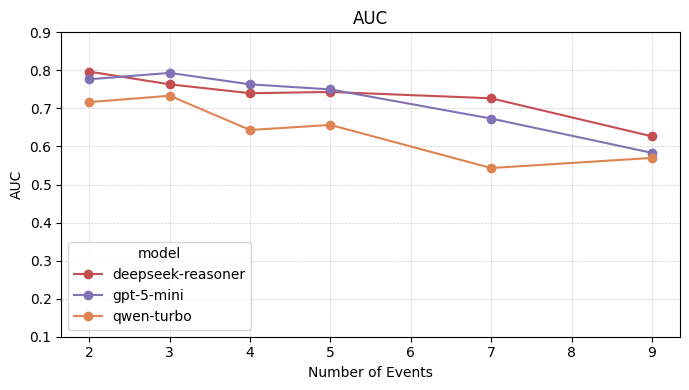

In [90]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(0.1, 1, 0.1))
plot_lines(least_to_most_fixed_f_df, x='number_of_events', y='auc', z='model', title='AUC', x_label='Number of Events',
           y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

### Accuracy Drop Analysis

In [91]:
# Combine all strategy dataframes from this section
all_strategies_df = pd.concat([
    direct_fixed_f_df.assign(strategy='direct'),
    zero_shot_cot_fixed_f_df.assign(strategy='zero_shot_cot'),
    few_shot_cot_fixed_f_df.assign(strategy='few_shot_cot'),
    self_consistency_fixed_f_df.assign(strategy='self_consistency'),
    least_to_most_fixed_f_df.assign(strategy='least_to_most')
], ignore_index=True)

# Calculate accuracy drop from event 2 to event 9
# Convert accuracy to percentage (multiply by 100)
event2_data = all_strategies_df[all_strategies_df['number_of_events'] == 2][['accuracy', 'strategy', 'model']].copy()
event2_data['accuracy'] = event2_data['accuracy'] * 100
event9_data = all_strategies_df[all_strategies_df['number_of_events'] == 9][['accuracy', 'strategy', 'model']].copy()
event9_data['accuracy'] = event9_data['accuracy'] * 100

# Merge the data on both strategy and model
accuracy_drop_df = event2_data.merge(event9_data, on=['strategy', 'model'], suffixes=('_event2', '_event9'))

# Calculate the drop (in percentage points)
accuracy_drop_df['accuracy_drop'] = accuracy_drop_df['accuracy_event2'] - accuracy_drop_df['accuracy_event9']

# Display the results
print("Accuracy Drop from Event 2 to Event 9 (by Model and Strategy):")
print("="*80)
print(accuracy_drop_df[['model', 'strategy', 'accuracy_event2', 'accuracy_event9', 'accuracy_drop']].to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("\nSummary Statistics:")
print(f"Average accuracy drop across all models and methods: {accuracy_drop_df['accuracy_drop'].mean():.2f} percentage points")
print(f"Std deviation: {accuracy_drop_df['accuracy_drop'].std():.2f} percentage points")
print(f"Min drop: {accuracy_drop_df['accuracy_drop'].min():.2f} percentage points")
print(f"Max drop: {accuracy_drop_df['accuracy_drop'].max():.2f} percentage points")

# Breakdown by strategy
print("\n" + "="*80)
print("\nAverage Drop by Strategy:")
strategy_drops = accuracy_drop_df.groupby('strategy')['accuracy_drop'].agg(['mean', 'std']).round(2)
print(strategy_drops.to_string())
print("\nMean Drop by Strategy:")
print(strategy_drops.mean())

# Breakdown by model
print("\n" + "="*80)
print("\nAverage Drop by Model:")
model_drops = accuracy_drop_df.groupby('model')['accuracy_drop'].agg(['mean', 'std']).round(2)
print(model_drops.to_string())
print("\nMean Drop by Model:")
print(model_drops.mean())

Accuracy Drop from Event 2 to Event 9 (by Model and Strategy):
            model         strategy  accuracy_event2  accuracy_event9  accuracy_drop
deepseek-reasoner           direct        79.666667        60.000000      19.666667
       gpt-5-mini           direct        79.333333        64.333333      15.000000
       qwen-turbo           direct        70.666667        56.666667      14.000000
deepseek-reasoner    zero_shot_cot        78.666667        59.333333      19.333333
       gpt-5-mini    zero_shot_cot        78.333333        60.000000      18.333333
       qwen-turbo    zero_shot_cot        73.333333        54.666667      18.666667
deepseek-reasoner     few_shot_cot        91.333333        68.666667      22.666667
       gpt-5-mini     few_shot_cot        97.666667        86.666667      11.000000
       qwen-turbo     few_shot_cot        82.000000        57.333333      24.666667
deepseek-reasoner self_consistency        79.333333        59.000000      20.333333
       gpt-5-

# Strategy Analysis

In [92]:
models = ["gpt-3.5-turbo", "gpt-4o-mini", "gpt-5-mini", "gemma3:12b-it-q8_0", "mistral:7b-instruct",
          "deepseek-reasoner", "deepseek-chat", "phi4:14b", "qwen-turbo", "qwen2.5-72b-instruct",
          "qwen3-14b", "qwen3-32b"]
strategies = ["direct", "zero_shot_cot", "few_shot_cot", "self_consistency", "least_to_most"]

## 1. LTLBench: Event 3, Operator 3, Count 2000

In [93]:
def show_strategies_comparison(_models: list[str], _strategies: list[str], _event_n=3, _formula_n=3, _count=2000):
    """Compare strategies across models for a fixed configuration"""
    all_strategies_data = []

    for _strategy in _strategies:
        strategy_metrics = []
        for _model in _models:
            _path = get_evaluation_file_path(
                event_n=_event_n,
                formula_n=_formula_n,
                count=_count,
                model=_model,
                strategy=_strategy
            )
            if not os.path.exists(_path):
                warnings.warn(
                    f"Evaluation file for model '{_model}', strategy '{_strategy}' does not exist.",
                    UserWarning
                )
                continue
            _df = pd.read_csv(_path)
            _df["answer"] = _df["answer"].apply(lambda x: 1 if x else 0)
            _df["prediction"] = _df["prediction"].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
            strategy_metrics.append(metrics(_df)["raw"])

        # Calculate average metrics across all models for this strategy
        if strategy_metrics:
            avg_metrics = pd.DataFrame(strategy_metrics).mean().to_dict()
            avg_metrics["strategy"] = _strategy
            all_strategies_data.append(avg_metrics)

    # Create DataFrame with strategy as index
    result_df = pd.DataFrame(all_strategies_data)
    result_df = result_df.set_index("strategy")

    return result_df

In [94]:
strategies_comparison_df = show_strategies_comparison(models, strategies)
strategies_comparison_df

,accuracy,precision,recall,f1,auc
strategy,,,,,
direct,0.658292,0.665428,0.658292,0.651010,0.658292
zero_shot_cot,0.671792,0.677098,0.671792,0.669172,0.671792
few_shot_cot,0.763292,0.766810,0.763292,0.762632,0.763292
self_consistency,0.682875,0.687246,0.682875,0.680397,0.682875
least_to_most,0.682125,0.688933,0.682125,0.671290,0.682125


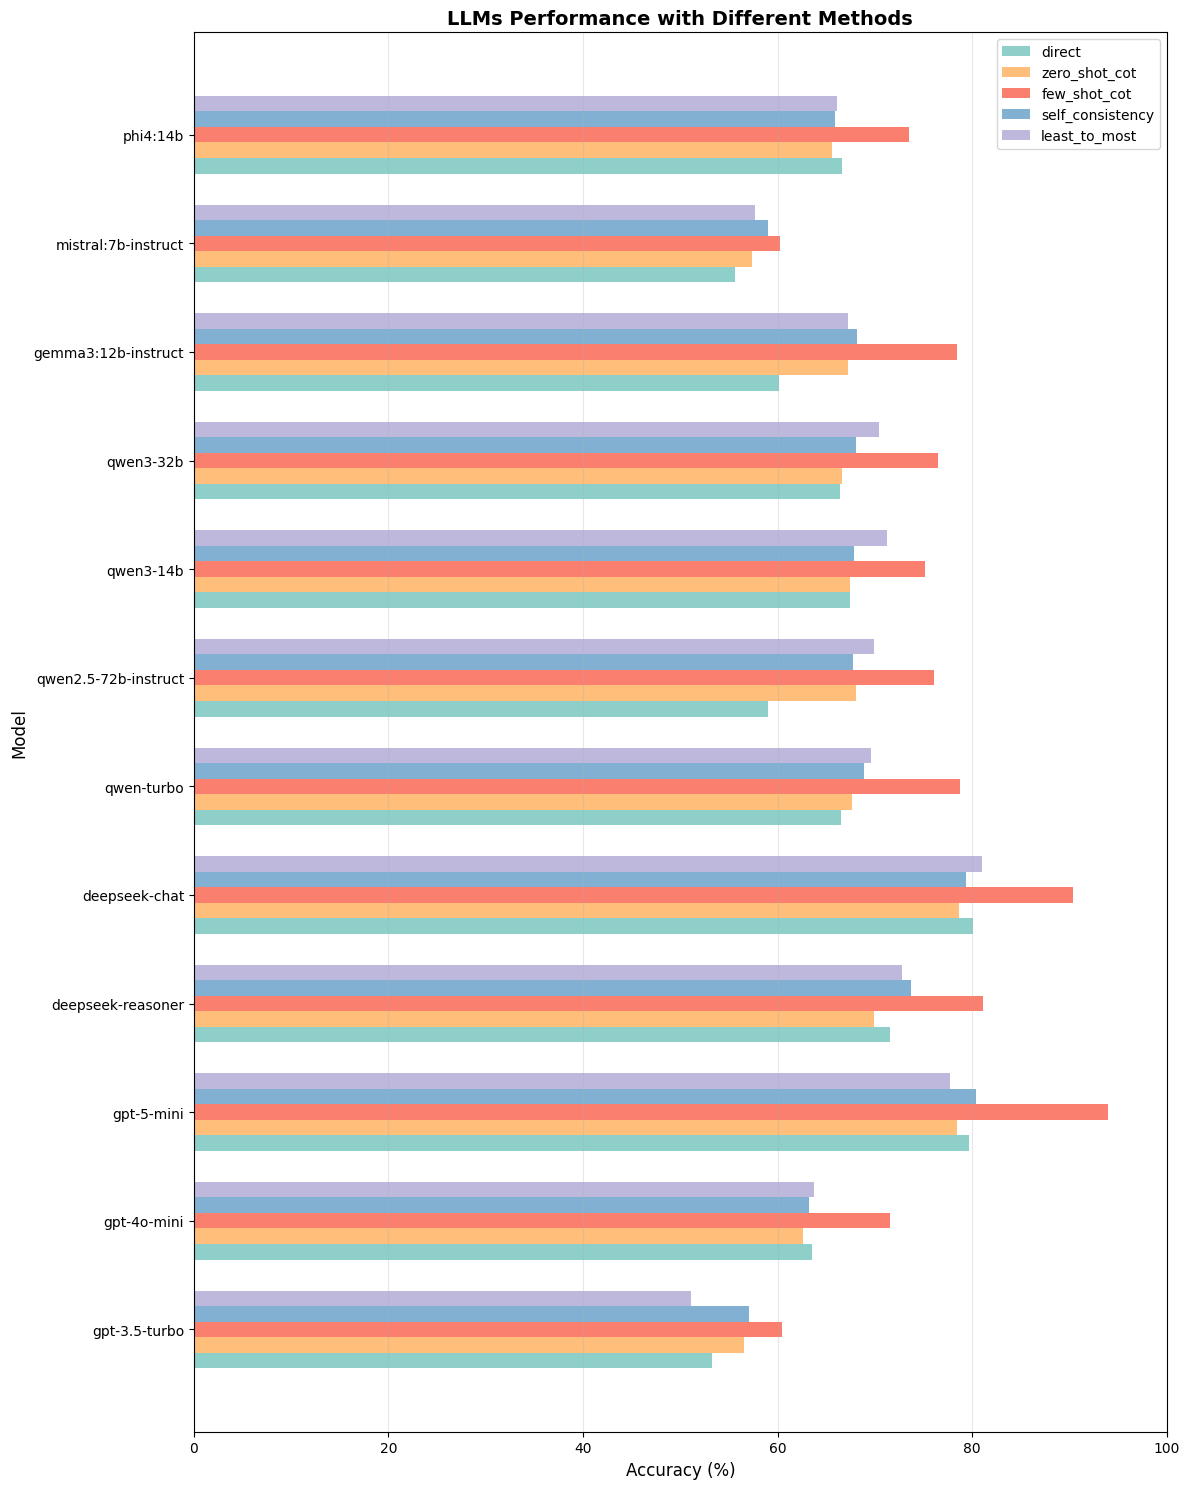

In [95]:
# A bar plot (y-axis is model, x-axis is accuracy, z-axis is strategy), which means a model has multiple bars to show accuracy of each strategy
import matplotlib.pyplot as plt
import numpy as np

# Reorder models: GPT models, DeepSeek models, Qwen models, Other models
models_ordered = [
    # GPT models
    "gpt-3.5-turbo", "gpt-4o-mini", "gpt-5-mini",
    # DeepSeek models
    "deepseek-reasoner", "deepseek-chat",
    # Qwen models
    "qwen-turbo", "qwen2.5-72b-instruct", "qwen3-14b", "qwen3-32b",
    # Other models
    "gemma3:12b-it-q8_0", "mistral:7b-instruct", "phi4:14b"
]
display_names = {
    "gemma3:12b-it-q8_0": "gemma3:12b-instruct"
}
ytick_labels = [
    display_names.get(m, m) for m in models_ordered
]

# Prepare data for plotting
fig, ax = plt.subplots(figsize=(12, 15))

# Define color palette from the provided colors
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC']

# Set up bar positions
strategies_list = strategies_comparison_df.index.tolist()
n_models = len(models_ordered)
n_strategies = len(strategies_list)
bar_height = 0.15  # height of each bar
group_gap = 0.3  # gap between model groups

# Create y positions for each model group
y_positions = np.arange(n_models) * (n_strategies * bar_height + group_gap)

# Plot bars for each strategy
for idx, strategy in enumerate(strategies_list):
    strategy_accuracies = []
    for model in models_ordered:
        # Get accuracy for this model and strategy
        _path = get_evaluation_file_path(
            event_n=3,
            formula_n=3,
            count=2000,
            model=model,
            strategy=strategy
        )
        if os.path.exists(_path):
            _df = pd.read_csv(_path)
            _df["answer"] = _df["answer"].apply(lambda x: 1 if x else 0)
            _df["prediction"] = _df["prediction"].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
            acc = metrics(_df)["raw"]["accuracy"]
            strategy_accuracies.append(acc * 100)  # Convert to percentage
        else:
            warnings.warn(f"Evaluation file of model '{model}' with strategy '{strategy}' does not exist.", UserWarning)
            strategy_accuracies.append(0)

    # Calculate y positions for this strategy
    y_offsets = y_positions + idx * bar_height
    ax.barh(y_offsets, strategy_accuracies, bar_height, label=strategy, color=colors[idx])

ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('LLMs Performance with Different Methods', fontsize=14, fontweight='bold')
ax.set_yticks(y_positions + bar_height * (n_strategies - 1) / 2)
ax.set_yticklabels(ytick_labels, fontsize=10)
ax.legend(loc='best', fontsize=10)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

## 2. Event 2, Operator 1-9, Count 300

In [96]:
def show_strategies_across_operators(_models: list[str], _strategies: list[str], _event_n=2, _count=300,
                                     _formulas: Union[list[int], None] = None):
    """Compare strategies across varying number of operators, averaged across models"""
    if _formulas is None:
        _formulas = [1, 2, 3, 4, 5, 7, 9]

    all_strategies_df = pd.DataFrame()

    for _strategy in _strategies:
        strategy_data = {}
        for _formula_n in _formulas:
            formula_metrics = []
            for _model in _models:
                _path = get_evaluation_file_path(
                    event_n=_event_n,
                    formula_n=_formula_n,
                    count=_count,
                    model=_model,
                    strategy=_strategy
                )
                if not os.path.exists(_path):
                    continue
                _df = pd.read_csv(_path)
                _df["answer"] = _df["answer"].apply(lambda x: 1 if x else 0)
                _df["prediction"] = _df["prediction"].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
                formula_metrics.append(metrics(_df)["raw"])

            # Average across all models for this formula
            if formula_metrics:
                strategy_data[_formula_n] = pd.DataFrame(formula_metrics).mean().to_dict()

        # Convert to DataFrame
        strategy_df = (
            pd.DataFrame(strategy_data)
            .transpose()
            .reset_index()
            .rename(columns={"index": "number_of_operators"})
        )
        strategy_df["strategy"] = _strategy

        all_strategies_df = pd.concat([all_strategies_df, strategy_df], ignore_index=True)

    return all_strategies_df

In [97]:
strategies_across_operators_df = show_strategies_across_operators(models, strategies)
strategies_across_operators_df

,number_of_operators,accuracy,precision,recall,f1,auc,strategy
0,1,0.721111,0.731827,0.721111,0.716950,0.721111,direct
1,2,0.765556,0.767266,0.765556,0.764993,0.765556,direct
2,3,0.707778,0.709869,0.707778,0.707052,0.707778,direct
3,4,0.772222,0.782063,0.772222,0.770001,0.772222,direct
4,5,0.761111,0.776091,0.761111,0.756578,0.761111,direct
5,7,0.778889,0.796807,0.778889,0.773215,0.778889,direct
6,9,0.714444,0.744519,0.714444,0.699758,0.714444,direct
7,1,0.736667,0.743242,0.736667,0.734878,0.736667,zero_shot_cot
8,2,0.767778,0.769308,0.767778,0.767358,0.767778,zero_shot_cot
9,3,0.701111,0.702726,0.701111,0.700540,0.701111,zero_shot_cot


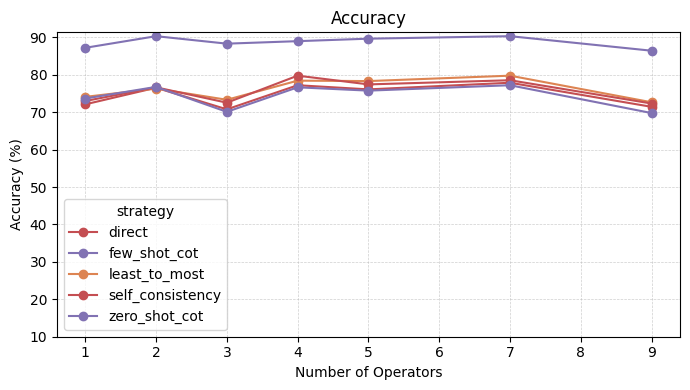

In [98]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(10, 100, 10))
plot_lines(strategies_across_operators_df, x='number_of_operators', y='accuracy', z='strategy', title='Accuracy',
           x_label='Number of Operators',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

## 3. Operator 2, Event 2-9, Count 300

In [99]:
def show_strategies_across_events(_models: list[str], _strategies: list[str], _formula_n=2, _count=300,
                                  _events: Union[list[int], None] = None):
    """Compare strategies across varying number of events, averaged across models"""
    if _events is None:
        _events = [2, 3, 4, 5, 7, 9]

    all_strategies_df = pd.DataFrame()

    for _strategy in _strategies:
        strategy_data = {}
        for _event_n in _events:
            event_metrics = []
            for _model in _models:
                _path = get_evaluation_file_path(
                    event_n=_event_n,
                    formula_n=_formula_n,
                    count=_count,
                    model=_model,
                    strategy=_strategy
                )
                if not os.path.exists(_path):
                    continue
                _df = pd.read_csv(_path)
                _df["answer"] = _df["answer"].apply(lambda x: 1 if x else 0)
                _df["prediction"] = _df["prediction"].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
                event_metrics.append(metrics(_df)["raw"])

            # Average across all models for this event
            if event_metrics:
                strategy_data[_event_n] = pd.DataFrame(event_metrics).mean().to_dict()

        # Convert to DataFrame
        strategy_df = (
            pd.DataFrame(strategy_data)
            .transpose()
            .reset_index()
            .rename(columns={"index": "number_of_events"})
        )
        strategy_df["strategy"] = _strategy

        all_strategies_df = pd.concat([all_strategies_df, strategy_df], ignore_index=True)

    return all_strategies_df

In [100]:
strategies_across_events_df = show_strategies_across_events(models, strategies)
strategies_across_events_df

,number_of_events,accuracy,precision,recall,f1,auc,strategy
0,2,0.765556,0.767266,0.765556,0.764993,0.765556,direct
1,3,0.752222,0.754232,0.752222,0.751749,0.752222,direct
2,4,0.705556,0.719622,0.705556,0.701418,0.705556,direct
3,5,0.723333,0.738894,0.723333,0.719752,0.723333,direct
4,7,0.635556,0.670295,0.635556,0.622082,0.635556,direct
5,9,0.603333,0.640564,0.603333,0.579687,0.603333,direct
6,2,0.767778,0.769308,0.767778,0.767358,0.767778,zero_shot_cot
7,3,0.744444,0.749291,0.744444,0.743076,0.744444,zero_shot_cot
8,4,0.702222,0.716052,0.702222,0.698288,0.702222,zero_shot_cot
9,5,0.711111,0.727306,0.711111,0.707145,0.711111,zero_shot_cot


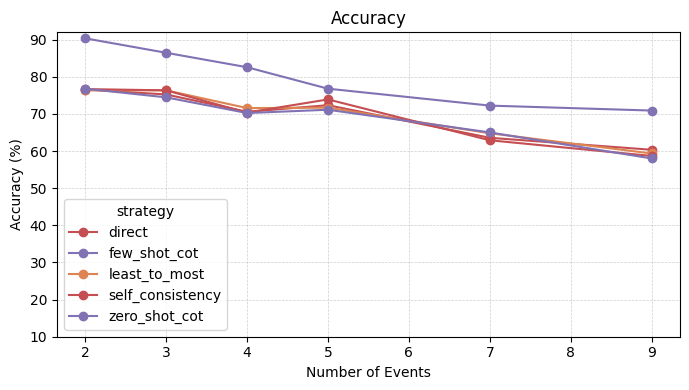

In [101]:
x_ticks = list(np.arange(2, 10))
y_ticks = list(np.arange(10, 100, 10))
plot_lines(strategies_across_events_df, x='number_of_events', y='accuracy', z='strategy', title='Accuracy',
           x_label='Number of Events',
           y_label='Accuracy (%)', x_ticks=x_ticks, y_ticks=y_ticks, as_percentage=True)

# Qualitative Analysis

In [102]:
models = ["gpt-3.5-turbo", "gpt-4o-mini", "gpt-5-mini", "gemma3:12b-it-q8_0", "mistral:7b-instruct",
          "deepseek-reasoner",
          "deepseek-chat", "phi4:14b", "qwen-turbo", "qwen2.5-72b-instruct", "qwen3-14b", "qwen3-32b"]
strategies = ["direct", "zero_shot_cot", "few_shot_cot", "self_consistency", "least_to_most"]

# Randomly sample 10 examples from each model-strategy result pair
all_samples = []

for model in models:
    for strategy in strategies:
        file_path = get_evaluation_file_path(
            event_n=3,
            formula_n=3,
            count=2000,
            model=model,
            strategy=strategy
        )
        if not os.path.exists(file_path):
            warnings.warn(
                f"Evaluation file for model '{model}', strategy '{strategy}' does not exist.",
                UserWarning
            )
            continue
        df = pd.read_csv(file_path)
        # Randomly sample 10 rows (fixed seed for reproduction)
        sample_df = df.sample(n=min(10, len(df)), random_state=42, replace=False)
        # Calculate correctness
        sample_df['answer_int'] = sample_df['answer'].apply(lambda x: 1 if x else 0)
        sample_df['prediction_int'] = sample_df['prediction'].apply(lambda x: 1 if pd.notna(x) and x == 1 else 0)
        sample_df['correctness'] = sample_df['answer_int'] == sample_df['prediction_int']

        # Add samples to list
        for _, row in sample_df.iterrows():
            all_samples.append({
                'model': model,
                'strategy': strategy,
                'code': row['code'],
                'problem': row['question'],
                'answer': row['answer'],
                'correctness': row['correctness'],
                'raw_response': row['prediction_raw']
            })

# Create final dataframe
qualitative_samples_df = pd.DataFrame(all_samples)

print(f"Total samples collected: {len(qualitative_samples_df)}")
print(f"Samples per model-strategy combination: 10")
print(f"Total model-strategy combinations: {len(models) * len(strategies)}")
print(f"\nDataframe shape: {qualitative_samples_df.shape}")
print(f"\nColumns: {qualitative_samples_df.columns.tolist()}")
print(f"\nCorrectness distribution:")
print(qualitative_samples_df['correctness'].value_counts())
print(f"\nFirst few rows:")
qualitative_samples_df[qualitative_samples_df["correctness"]==False].to_csv("./qualitative_analysis_samples.csv")
qualitative_samples_df[qualitative_samples_df["correctness"]==False]

Total samples collected: 600
Samples per model-strategy combination: 10
Total model-strategy combinations: 60

Dataframe shape: (600, 7)

Columns: ['model', 'strategy', 'code', 'problem', 'answer', 'correctness', 'raw_response']

Correctness distribution:
correctness
True     455
False    145
Name: count, dtype: int64

First few rows:


,model,strategy,code,problem,answer,correctness,raw_response
2,gpt-3.5-turbo,direct,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event3 happened....",False,False,True
4,gpt-3.5-turbo,direct,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event3 happened....",False,False,True
7,gpt-3.5-turbo,direct,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event2 happened....",False,False,True
9,gpt-3.5-turbo,direct,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event1 happened....",False,False,True
10,gpt-3.5-turbo,zero_shot_cot,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event1 happened....",False,False,"First, let's break down the hypothesis:\n\nC1:..."
...,...,...,...,...,...,...,...
584,qwen3-32b,self_consistency,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event3 happened....",False,False,Generated 3 samples.\nVotes: {'True': 3}\nFina...
585,qwen3-32b,self_consistency,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event2 happened....",False,False,"Generated 3 samples.\nVotes: {'False': 1, 'Tru..."
589,qwen3-32b,self_consistency,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event1 happened....",False,False,Generated 3 samples.\nVotes: {'True': 3}\nFina...
598,qwen3-32b,least_to_most,"MODULE main\nVAR\n state : {event1, event2,...","=== Context ===\n\nInitially, event3 happened....",True,False,=== Step 1: Problem Breakdown ===\nLet's break...
